In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from apyori import apriori

In [30]:
# Step 1: Data Collection
df = pd.read_excel('data/online_retail_II.xlsx')
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [31]:
df.columns

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')

In [32]:
df.Country.unique()

array(['United Kingdom', 'France', 'USA', 'Belgium', 'Australia', 'EIRE',
       'Germany', 'Portugal', 'Japan', 'Denmark', 'Nigeria',
       'Netherlands', 'Poland', 'Spain', 'Channel Islands', 'Italy',
       'Cyprus', 'Greece', 'Norway', 'Austria', 'Sweden',
       'United Arab Emirates', 'Finland', 'Switzerland', 'Unspecified',
       'Malta', 'Bahrain', 'RSA', 'Bermuda', 'Hong Kong', 'Singapore',
       'Thailand', 'Israel', 'Lithuania', 'West Indies', 'Lebanon',
       'Korea', 'Brazil', 'Canada', 'Iceland'], dtype=object)

In [33]:
# Print the total number of transactions (rows)
print("\nTotal number of transactions (rows):", len(df))


Total number of transactions (rows): 525461


In [34]:
# Print the number of unique items (assuming 'Description' is the item column)
unique_items = df['Description'].nunique()
print("\nNumber of unique items:", unique_items)


Number of unique items: 4681


In [35]:
# Step 2: Data processing

# drop missing values
missing_data = df.dropna(subset=["Description","StockCode","Invoice"])

# remove stockCodes which start with 'C'
rm_data = missing_data[~missing_data['StockCode'].astype(str).str.startswith('C')]
transactions = rm_data.groupby('Invoice')['Description'].apply(list).values

# convert transactions to list and remove duplicates
transaction_list = [list(set(transaction)) for transaction in transactions]
print(f"======> Total Transactions: {len(transaction_list)} rows  <======", )

# find with 7 records
transaction_limit = transaction_list[:7]

unique_item_transactions = [item for transaction in transaction_limit for item in transaction]
count = len(unique_item_transactions)
print(f"======> Unique item transactions: {count} <======")

print("======> Items <======")
for transaction in transaction_limit:
    print(f"Transaction: {transaction}, Length: {len(transaction)}")

======> Total Transactions: 25880 rows  <======
======> Unique item transactions: 92 <======
======> Items <======
Transaction: ['PINK CHERRY LIGHTS', '15CM CHRISTMAS GLASS BALL 20 LIGHTS', 'STRAWBERRY CERAMIC TRINKET BOX', 'RECORD FRAME 7" SINGLE SIZE ', 'SAVE THE PLANET MUG', ' WHITE CHERRY LIGHTS', 'FANCY FONT HOME SWEET HOME DOORMAT', 'PINK DOUGHNUT TRINKET POT '], Length: 8
Transaction: ['CAT BOWL ', 'HEART MEASURING SPOONS LARGE', 'LUNCHBOX WITH CUTLERY FAIRY CAKES ', 'DOG BOWL , CHASING BALL DESIGN'], Length: 4
Transaction: ['SMALL MARSHMALLOWS PINK BOWL', ' PEACE WOODEN BLOCK LETTERS', 'BISCUITS SMALL BOWL LIGHT BLUE', 'HEART IVORY TRELLIS LARGE', 'HEART FILIGREE DOVE LARGE', 'PLEASE ONE PERSON  METAL SIGN', 'BATH BUILDING BLOCK WORD', 'CLASSIC WHITE FRAME', 'SET OF 3 BLACK FLYING DUCKS', 'AREA PATROLLED METAL SIGN', 'HOME BUILDING BLOCK WORD', 'SCOTTIE DOG HOT WATER BOTTLE', 'CHRISTMAS CRAFT WHITE FAIRY ', 'DOOR MAT BLACK FLOCK ', 'PIZZA PLATE IN BOX', 'LOVE BUILDING BLOCK WOR

In [36]:
# Step 3 : Show Binary matrix

# ensure all items are string
str_transaction = [[str(item) for item in set(transaction)] for transaction in transactions]

tranEncode = TransactionEncoder()
tranEncodeArray = tranEncode.fit(transaction_limit).transform(transaction_limit)
binary_matrix = pd.DataFrame(tranEncodeArray, columns=tranEncode.columns_)
print("======> Binary Matrix <====== \n" , binary_matrix.astype(int))

======> Binary Matrix <====== 
     PEACE WOODEN BLOCK LETTERS   VINTAGE DESIGN GIFT TAGS  \
0                            0                          0   
1                            0                          0   
2                            1                          0   
3                            0                          0   
4                            0                          0   
5                            0                          1   
6                            0                          0   

    WHITE CHERRY LIGHTS  15CM CHRISTMAS GLASS BALL 20 LIGHTS  \
0                     1                                    1   
1                     0                                    0   
2                     0                                    0   
3                     0                                    0   
4                     0                                    0   
5                     0                                    0   
6                     0        

In [37]:
# Debugging: Print a sample of the transaction_list
print("Sample transactions before apriori:")
for t in transaction_list[:5]:  # Print the first 5 transactions
    print(t)

Sample transactions before apriori:
['PINK CHERRY LIGHTS', '15CM CHRISTMAS GLASS BALL 20 LIGHTS', 'STRAWBERRY CERAMIC TRINKET BOX', 'RECORD FRAME 7" SINGLE SIZE ', 'SAVE THE PLANET MUG', ' WHITE CHERRY LIGHTS', 'FANCY FONT HOME SWEET HOME DOORMAT', 'PINK DOUGHNUT TRINKET POT ']
['CAT BOWL ', 'HEART MEASURING SPOONS LARGE', 'LUNCHBOX WITH CUTLERY FAIRY CAKES ', 'DOG BOWL , CHASING BALL DESIGN']
['SMALL MARSHMALLOWS PINK BOWL', ' PEACE WOODEN BLOCK LETTERS', 'BISCUITS SMALL BOWL LIGHT BLUE', 'HEART IVORY TRELLIS LARGE', 'HEART FILIGREE DOVE LARGE', 'PLEASE ONE PERSON  METAL SIGN', 'BATH BUILDING BLOCK WORD', 'CLASSIC WHITE FRAME', 'SET OF 3 BLACK FLYING DUCKS', 'AREA PATROLLED METAL SIGN', 'HOME BUILDING BLOCK WORD', 'SCOTTIE DOG HOT WATER BOTTLE', 'CHRISTMAS CRAFT WHITE FAIRY ', 'DOOR MAT BLACK FLOCK ', 'PIZZA PLATE IN BOX', 'LOVE BUILDING BLOCK WORD', 'ASSORTED COLOUR BIRD ORNAMENT', 'FULL ENGLISH BREAKFAST PLATE', 'BLACK DINER WALL CLOCK']
['CHRISTMAS CRAFT HEART STOCKING ', 'BLUE PAD

In [38]:
#step4: Frequent One Itemset Generation (Transaction Creation)
transactions = df.groupby('Invoice')['Description'].apply(list).values
transaction_list = [list(set(transaction)) for transaction in transactions]
print("Total transactions:", len(transaction_list))

Total transactions: 28816


In [39]:
#step5: Remove Duplicate Data and Generating RC
transaction_list = [[str(item) for item in set(transaction)] for transaction in transactions]


In [40]:
#step6: Automatic Find Actual Minimum Support
min_support = 0.02
min_confidence = 0.3
min_lift = 1.0


In [41]:
#step7: Generate Frequent Itemset
# Run the Apriori algorithm
rules = apriori(transaction_list, min_support=min_support, 
                min_confidence=min_confidence, min_lift=min_lift)

# Convert results to a list for readability
results = list(rules)
print("Total rules generated:", len(results))

Total rules generated: 6


In [42]:
# Step 8: Association Rule
print("\n=== Association Rules ===")
for rule in results:
    items = [x for x in rule.items]
    print(f"Rule: {items}")
    print(f"Support: {rule.support:.4f}")
    for ordered_stat in rule.ordered_statistics:
        print(f"Confidence: {ordered_stat.confidence:.4f}")
        print(f"Lift: {ordered_stat.lift:.4f}")
    print("-" * 30)



=== Association Rules ===
Rule: ['60 TEATIME FAIRY CAKE CASES', 'PACK OF 60 PINK PAISLEY CAKE CASES']
Support: 0.0206
Confidence: 0.4434
Lift: 11.0139
Confidence: 0.5129
Lift: 11.0139
------------------------------
Rule: ['60 TEATIME FAIRY CAKE CASES', 'PACK OF 72 RETRO SPOT CAKE CASES']
Support: 0.0210
Confidence: 0.4501
Lift: 9.1398
Confidence: 0.4257
Lift: 9.1398
------------------------------
Rule: ['LOVE BUILDING BLOCK WORD', 'HOME BUILDING BLOCK WORD']
Support: 0.0204
Confidence: 0.4377
Lift: 11.4358
Confidence: 0.5322
Lift: 11.4358
------------------------------
Rule: ['WHITE HANGING HEART T-LIGHT HOLDER', 'RED HANGING HEART T-LIGHT HOLDER']
Support: 0.0271
Confidence: 0.7169
Lift: 6.0600
------------------------------
Rule: ['SWEETHEART CERAMIC TRINKET BOX', 'STRAWBERRY CERAMIC TRINKET BOX']
Support: 0.0284
Confidence: 0.4629
Lift: 12.7654
Confidence: 0.7828
Lift: 12.7654
------------------------------
Rule: ['WOODEN PICTURE FRAME WHITE FINISH', 'WOODEN FRAME ANTIQUE WHITE ']


In [43]:
# Step 9: End
results_df = pd.DataFrame([(tuple(result.items), result.support) 
                           for result in results], 
                          columns=['Itemset', 'Support'])

print("\nFrequent Itemsets:")
display(results_df)



Frequent Itemsets:


,Itemset,Support
0,"(60 TEATIME FAIRY CAKE CASES, PACK OF 60 PINK ...",0.020648
1,"(60 TEATIME FAIRY CAKE CASES, PACK OF 72 RETRO...",0.020961
2,"(LOVE BUILDING BLOCK WORD, HOME BUILDING BLOCK...",0.020371
3,"(WHITE HANGING HEART T-LIGHT HOLDER, RED HANGI...",0.027068
4,"(SWEETHEART CERAMIC TRINKET BOX, STRAWBERRY CE...",0.028387
5,"(WOODEN PICTURE FRAME WHITE FINISH, WOODEN FRA...",0.021134


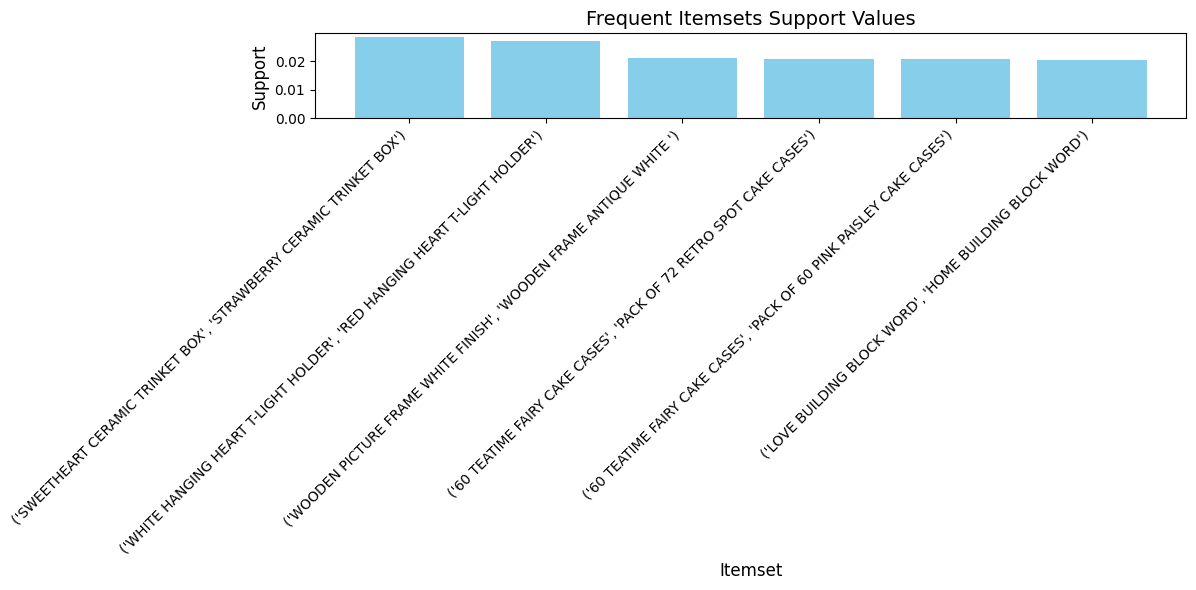

In [44]:
#Display graph
# Sort the results by support for better visualization
sorted_results = results_df.sort_values(by='Support', ascending=False)

# Plot a bar chart
plt.figure(figsize=(12, 6))
plt.bar(sorted_results['Itemset'].astype(str), sorted_results['Support'], color='skyblue')

# Add labels and title
plt.xlabel('Itemset', fontsize=12)
plt.ylabel('Support', fontsize=12)
plt.title('Frequent Itemsets Support Values', fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=10)

# Display the graph
plt.tight_layout()
plt.show()